**Importing Data from .mat files**
This includes all characteristics

In [1]:

import scipy.io
import numpy as np

num_trajs = 50
n_bs = 4
n_paths = 25
n_time = 3e3
n_features = 6

mat = scipy.io.loadmat('all_azimuth_aoa_tensor_paths.mat')
azimuth_aoa_tensor = mat['azimuth_aoa_tensor'] # dimensions are n_traj x n_time x n_bs x n_paths
azimuth_aoa_tensor = np.reshape(azimuth_aoa_tensor,(int(num_trajs*n_time),n_bs,n_paths))


mat = scipy.io.loadmat('all_azimuth_aod_tensor_paths.mat')
azimuth_aod_tensor = mat['azimuth_aod_tensor'] # dimensions are n_traj x n_time x n_bs x n_paths
azimuth_aod_tensor = np.reshape(azimuth_aod_tensor,(int(num_trajs*n_time),n_bs,n_paths))

mat = scipy.io.loadmat('all_zenith_aod_tensor_paths.mat')
zenith_aod_tensor = mat['zenith_aod_tensor'] # dimensions are n_traj x n_time x n_bs x n_paths
zenith_aod_tensor = np.reshape(zenith_aod_tensor,(int(num_trajs*n_time),n_bs,n_paths))

mat = scipy.io.loadmat('all_zenith_aoa_tensor_paths.mat')
zenith_aoa_tensor = mat['zenith_aoa_tensor'] # dimensions are n_traj x n_time x n_bs x n_paths
zenith_aoa_tensor = np.reshape(zenith_aoa_tensor,(int(num_trajs*n_time),n_bs,n_paths))


mat = scipy.io.loadmat('all_rxpower_tensor_paths.mat')
rx_power_tensor = mat['rx_power_tensor'] # dimensions are n_traj x n_time x n_bs x n_paths
rx_power_tensor = np.reshape(rx_power_tensor,(int(num_trajs*n_time),n_bs,n_paths))
rx_power_tensor = 10**(0.1*rx_power_tensor) # in Watts

mat = scipy.io.loadmat('all_toa_tensor_paths.mat')
toa_tensor = mat['toa_tensor'] # dimensions are n_traj x n_time x n_bs x n_paths
toa_tensor = np.reshape(toa_tensor,(int(num_trajs*n_time),n_bs,n_paths))*1e3 #in ms


mat = scipy.io.loadmat('all_true_tensor.mat')
true_cord_tensor = mat['true_cord_tensor'] # dimensions are n_traj x n_time x 3
true_cord_tensor = np.reshape(true_cord_tensor,(int(num_trajs*n_time),3))
del mat


**Constructing the input tensor with dimensions n_samples x n_bs x n_paths x n_features**

In [2]:
import math
input_tensor = np.zeros((int(num_trajs*n_time),n_bs,n_paths,n_features))*math.nan

n_samples = int(num_trajs*n_time)


input_tensor[:,:,:,0] = azimuth_aoa_tensor
del azimuth_aoa_tensor

input_tensor[:,:,:,1] = azimuth_aod_tensor
del azimuth_aod_tensor

input_tensor[:,:,:,2] = zenith_aoa_tensor
del zenith_aoa_tensor

input_tensor[:,:,:,3] = zenith_aod_tensor
del zenith_aod_tensor

input_tensor[:,:,:,4] = rx_power_tensor
del rx_power_tensor

input_tensor[:,:,:,5] = toa_tensor
del toa_tensor

print(np.sum(np.isnan(input_tensor))) ## making sure that there are no values left unassigned

0


Each input sample has a shape 600x1

In [3]:
import tensorflow as tf

from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

input_tensor = np.reshape(input_tensor,(n_samples,int(n_bs*n_paths*n_features)))

**Simple deep dense neural network (DDNN) approach**
Constructing DDNN and declaring all hyper-parameters. We tried batchnorm and dropout. It resulted in worse performance

In [4]:
from sklearn import preprocessing


input_tensor = input_tensor 
true_cord_tensor = true_cord_tensor - np.min(true_cord_tensor,axis = 0) ## assuming we know the minimum coordinates, done for stability of relu
true_cord_tensor = true_cord_tensor



model = models.Sequential()
model.add(layers.Dense(256, input_shape=(n_features*n_paths*n_bs,),activation = 'relu'))
model.add(layers.Dense(64,activation = 'relu'))
model.add(layers.Dense(3,activation = 'relu'))
print(model.summary())
opt = tf.keras.optimizers.Adam(learning_rate=5e-5)

model.compile(loss='mse', optimizer=opt)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               153856    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 195       
Total params: 170,499
Trainable params: 170,499
Non-trainable params: 0
_________________________________________________________________
None


Training split. Preprocessing data.


In [5]:


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(input_tensor, true_cord_tensor, test_size=0.5)


scaler = preprocessing.StandardScaler()
scaled_df = scaler.fit(X_train)
scaled_df = scaler.transform(X_train)

Running training. 

In [7]:
model.fit(scaled_df, y_train, epochs=500, batch_size=64, verbose = 2)

Epoch 1/500
1172/1172 - 2s - loss: 16253.0303
Epoch 2/500
1172/1172 - 2s - loss: 1362.4097
Epoch 3/500
1172/1172 - 2s - loss: 555.0094
Epoch 4/500
1172/1172 - 2s - loss: 347.7476
Epoch 5/500
1172/1172 - 2s - loss: 246.2486
Epoch 6/500
1172/1172 - 2s - loss: 188.0847
Epoch 7/500
1172/1172 - 2s - loss: 149.8009
Epoch 8/500
1172/1172 - 2s - loss: 122.3491
Epoch 9/500
1172/1172 - 2s - loss: 101.9748
Epoch 10/500
1172/1172 - 2s - loss: 86.2628
Epoch 11/500
1172/1172 - 2s - loss: 73.9157
Epoch 12/500
1172/1172 - 2s - loss: 63.9000
Epoch 13/500
1172/1172 - 2s - loss: 55.6905
Epoch 14/500
1172/1172 - 2s - loss: 48.7939
Epoch 15/500
1172/1172 - 2s - loss: 43.0781
Epoch 16/500
1172/1172 - 1s - loss: 38.1661
Epoch 17/500
1172/1172 - 1s - loss: 33.9650
Epoch 18/500
1172/1172 - 1s - loss: 30.3630
Epoch 19/500
1172/1172 - 2s - loss: 27.2551
Epoch 20/500
1172/1172 - 2s - loss: 24.5101
Epoch 21/500
1172/1172 - 2s - loss: 22.1529
Epoch 22/500
1172/1172 - 2s - loss: 20.0410
Epoch 23/500
1172/1172 - 2s -

Epoch 189/500
1172/1172 - 1s - loss: 0.0872
Epoch 190/500
1172/1172 - 1s - loss: 0.0827
Epoch 191/500
1172/1172 - 1s - loss: 0.0808
Epoch 192/500
1172/1172 - 1s - loss: 0.0933
Epoch 193/500
1172/1172 - 1s - loss: 0.0759
Epoch 194/500
1172/1172 - 1s - loss: 0.0742
Epoch 195/500
1172/1172 - 2s - loss: 0.0830
Epoch 196/500
1172/1172 - 1s - loss: 0.0825
Epoch 197/500
1172/1172 - 1s - loss: 0.0744
Epoch 198/500
1172/1172 - 1s - loss: 0.0806
Epoch 199/500
1172/1172 - 1s - loss: 0.0796
Epoch 200/500
1172/1172 - 1s - loss: 0.0749
Epoch 201/500
1172/1172 - 1s - loss: 0.0861
Epoch 202/500
1172/1172 - 2s - loss: 0.0675
Epoch 203/500
1172/1172 - 1s - loss: 0.0739
Epoch 204/500
1172/1172 - 1s - loss: 0.0744
Epoch 205/500
1172/1172 - 2s - loss: 0.0736
Epoch 206/500
1172/1172 - 1s - loss: 0.0773
Epoch 207/500
1172/1172 - 1s - loss: 0.0680
Epoch 208/500
1172/1172 - 1s - loss: 0.0752
Epoch 209/500
1172/1172 - 1s - loss: 0.0793
Epoch 210/500
1172/1172 - 1s - loss: 0.0685
Epoch 211/500
1172/1172 - 1s - l

1172/1172 - 3s - loss: 0.0404
Epoch 376/500
1172/1172 - 3s - loss: 0.0436
Epoch 377/500
1172/1172 - 3s - loss: 0.0472
Epoch 378/500
1172/1172 - 2s - loss: 0.0476
Epoch 379/500
1172/1172 - 2s - loss: 0.0404
Epoch 380/500
1172/1172 - 2s - loss: 0.0494
Epoch 381/500
1172/1172 - 1s - loss: 0.0524
Epoch 382/500
1172/1172 - 1s - loss: 0.0478
Epoch 383/500
1172/1172 - 1s - loss: 0.0427
Epoch 384/500
1172/1172 - 1s - loss: 0.0412
Epoch 385/500
1172/1172 - 1s - loss: 0.0456
Epoch 386/500
1172/1172 - 1s - loss: 0.0468
Epoch 387/500
1172/1172 - 1s - loss: 0.0460
Epoch 388/500
1172/1172 - 2s - loss: 0.0404
Epoch 389/500
1172/1172 - 2s - loss: 0.0460
Epoch 390/500
1172/1172 - 2s - loss: 0.0421
Epoch 391/500
1172/1172 - 2s - loss: 0.0406
Epoch 392/500
1172/1172 - 2s - loss: 0.0455
Epoch 393/500
1172/1172 - 1s - loss: 0.0425
Epoch 394/500
1172/1172 - 2s - loss: 0.0453
Epoch 395/500
1172/1172 - 2s - loss: 0.0416
Epoch 396/500
1172/1172 - 2s - loss: 0.0411
Epoch 397/500
1172/1172 - 1s - loss: 0.0433
Ep

Predicting on all data. 

In [9]:
pred_vals = model.predict(scaler.transform(input_tensor)) +  np.min(true_cord_tensor)*0

pred_train = model.predict(scaled_df)
pred_test = model.predict(scaler.transform(X_test))

In case we need to calculate errors in training, testing, overall. 

In [12]:
 #pred_vals = scaler.inverse_transform(pred_vals)
#pred_train = scaler.inverse_transform(pred_train)
#pred_test = scaler.inverse_transform(pred_test)

Calculating error norms. 

In [14]:
norm_error = np.linalg.norm(pred_vals - true_cord_tensor,axis = 1)
norm_error_train = np.linalg.norm(pred_train - y_train,axis = 1)
norm_error_test = np.linalg.norm(pred_test - y_test,axis = 1)
print(norm_error.shape)

(150000,)


Constructing CDFs. 

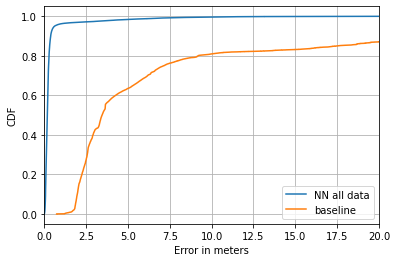

In [15]:
from statsmodels.distributions.empirical_distribution import ECDF

cdf = ECDF(norm_error/1)
plt.plot(cdf.x,cdf.y)
plt.grid()
plt.xlim([0,20])

# cdf = ECDF(norm_error_train/1)
# plt.plot(cdf.x,cdf.y)
# plt.grid()
# plt.xlim([0,20])


# cdf = ECDF(norm_error_test/1)
# plt.plot(cdf.x,cdf.y)
# plt.grid()
# plt.xlim([0,6])


mat = scipy.io.loadmat('baselineerror.mat')
err_data = mat['err_data']
err_data = (err_data).flatten()
cdf = ECDF(err_data*1)
plt.plot(cdf.x,cdf.y)

plt.xlabel('Error in meters')
plt.ylabel('CDF')
plt.legend(['NN all data','baseline'])

Mean error

In [17]:
print(np.mean(norm_error))
cdf = ECDF(norm_error/1)
y = cdf.y
indx = cdf.x[y>0.8]
#print(" {0}":)
print("The 80% percentile error in meters is ", indx[0], end='')

0.39238011261879013
The 80% percentile error in meters is  0.28855619859928044

Saving error array

In [18]:
#model.save('uav_localize_normalized_inputs_model')sio.
scipy.io.savemat('DDNN_no_noise_error.mat', {'norm_error':norm_error})